<a href="https://colab.research.google.com/github/LamineGith/PyTorch/blob/main/Text_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing (NLP)
NLP is a subfield of AI that helps machines better understand or generate human language. 
There is two main field in NLP: **Natural language understanding and Natural language generation**

NLP is very iused in **sentiment analysis, chatbot, marketing, speech recognition etc**.


# Text Data Processing 

Here I use the Text REtrieval Conference (TREC) which is a Question Classification Dataset

**Text REtrieval Conference (TREC) Question Classification Dataset**

*Data Examples and Six Categories:*

| Text | Label | Category |
| --- | --- | --- |
|CNN is the abbreviation for what ?|ABBR| ABBREVIATION |
| What is the date of Boxing Day ? | NUM |NUMERIC|
|Who discovered electricity ?| HUM |HUMAN|
|What 's the colored part of the eye called ?|ENTY|ENTITY|
|Why do horseshoes bring luck ?|DESC|DESCRIPTION|
|What is California 's capital ?|LOC|LOCATION|

In [ ]:
#https://github.com/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb 
# You have to install the version 1.8.0 and 0.9.0 of torchtext in other to have torchtext.legacy. 
!pip install -U torch==1.8.0 torchtext==0.9.0

import torch
from torchtext.legacy import data, datasets
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
seed = 966
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Fields**

[Check documentation](https://pytorch.org/text/_modules/torchtext/data/field.html)

In [ ]:
# define fields
TEXT = data.Field(tokenize='spacy', lower=True)
LABEL = data.LabelField()

In [ ]:
train, test = datasets.TREC.splits(TEXT, LABEL)
train, val = train.split(random_state=random.seed(seed))

In [ ]:
vars(train[-1])

{'text': ['how', 'do', 'you', 'say', '2', 'in', 'latin', '?'], 'label': 'ENTY'}

In [ ]:
# build vocab
TEXT.build_vocab(train, min_freq=2)
LABEL.build_vocab(train)

In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'ENTY': 0, 'HUM': 1, 'DESC': 2, 'NUM': 3, 'LOC': 4, 'ABBR': 5})


In [ ]:
print("Vocabulary size of TEXT:",len(TEXT.vocab.stoi))
print("Vocabulary size of LABEL:",len(LABEL.vocab.stoi))

Vocabulary size of TEXT: 2643
Vocabulary size of LABEL: 6


In [ ]:
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, val, test),
    batch_size = 64,
    sort_key=lambda x: len(x.text), 
    device=device
)

# Building a CNN model 

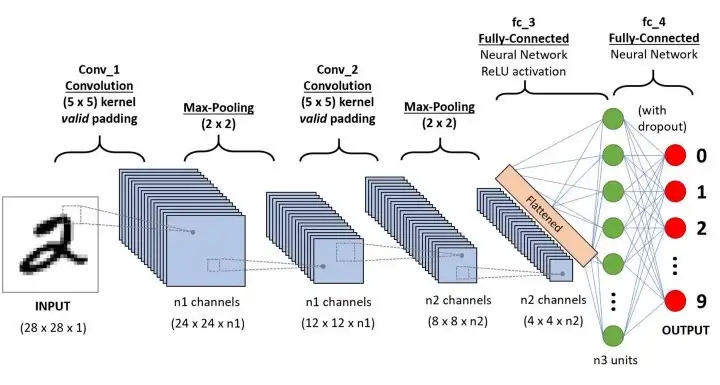

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

**Here is a description for some nn modules**



| Definition | nn.Module |
| --- | --- |
|This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.|*nn.Embedding*|
|ModuleList can be indexed like a regular Python list, but modules it contains are properly registered, and will be visible by all Module methods. | *nn.ModuleList* |
| Droupout is an effective technique for regularization and preventing the co-adaptation of neurons otherwise overfitting |*nn.Dropout*|

**Model build**


In [ ]:
class CNN(nn.Module):
  def __init__(self, vocabulary_size, embedding_size, 
               kernels_number, kernel_sizes, output_size, dropout_rate):
    super().__init__()
    self.embedding = nn.Embedding(vocabulary_size, embedding_size)
    self.convolution_layers = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=kernels_number,
                                                       kernel_size=(k, embedding_size))
                                                      for k in kernel_sizes])
    self.dropout = nn.Dropout(dropout_rate)
    self.fully_connected = nn.Linear(len(kernel_sizes) * kernels_number, output_size)
  def forward(self, text):
    text = text.permute(1, 0)
    input_embeddings = self.embedding(text)
    input_embeddings = input_embeddings.unsqueeze(1)
    conved = [F.relu(convolution_layer(input_embeddings)).squeeze(3) for convolution_layer in self.convolution_layers]
    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    concat = self.dropout(torch.cat(pooled, dim=1))
    final_output = self.fully_connected(concat)

    return final_output

**Kernel size**

In Convolutional neural network, the kernel is nothing but a filter that is used to extract the features from the images. The kernel is a matrix that moves over the input data, performs the dot product with the sub-region of input data, and gets the output as the matrix of dot products.

In [ ]:
vocabulary_size = 2679
embedding_size = 100
kernels_number = 100
kernel_sizes = [2, 3, 4]
output_size = 6
dropout_rate = 0.3

In [ ]:
model = CNN(vocabulary_size, embedding_size, kernels_number, kernel_sizes, output_size, dropout_rate)

In [ ]:
print(model)

CNN(
  (embedding): Embedding(2679, 100)
  (convolution_layers): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fully_connected): Linear(in_features=300, out_features=6, bias=True)
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (embedding): Embedding(2679, 100)
  (convolution_layers): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fully_connected): Linear(in_features=300, out_features=6, bias=True)
)

**Training and Evaluate functions**

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters())

In [ ]:
def accuracy(predictions, actual_label):
    max_predictions = predictions.argmax(dim = 1, keepdim = True, )
    correct_predictions = max_predictions.squeeze(1).eq(actual_label)
    accuracy = correct_predictions.sum() / torch.cuda.FloatTensor([actual_label.shape[0]])
    return accuracy

In [ ]:
def train(model, iterator, optimizer, criterion):

    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for batch in iterator:
        # optimizer
        optimizer.zero_grad()
        # predictions
        predictions = model(batch.text)
        # loss
        loss = criterion(predictions, batch.label)
        # accuracy
        acc = accuracy(predictions, batch.label)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text)
            
            loss = criterion(predictions, batch.label)
            
            acc = accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Training the model**

When running this script i got torch 10.2 but the cuda was not found, so you have install cuda 11.1 version. But you may not need that.

In [ ]:
 pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
number_of_epochs = 20

best_acc = float('-inf')

for epoch in range(number_of_epochs):
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'trec.pt')
    
    print(f'Epoch {epoch+1} ')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Validation Loss: {valid_loss:.3f} |  Validation Acc: {valid_acc*100:.2f}%')

Epoch 1 
	Train Loss: 1.314 | Train Acc: 47.51%
	 Validation Loss: 0.962 |  Validation Acc: 62.95%
Epoch 2 
	Train Loss: 0.792 | Train Acc: 70.89%
	 Validation Loss: 0.752 |  Validation Acc: 71.65%
Epoch 3 
	Train Loss: 0.595 | Train Acc: 79.12%
	 Validation Loss: 0.652 |  Validation Acc: 74.49%
Epoch 4 
	Train Loss: 0.463 | Train Acc: 85.18%
	 Validation Loss: 0.630 |  Validation Acc: 75.03%
Epoch 5 
	Train Loss: 0.361 | Train Acc: 88.90%
	 Validation Loss: 0.583 |  Validation Acc: 77.89%
Epoch 6 
	Train Loss: 0.282 | Train Acc: 91.78%
	 Validation Loss: 0.537 |  Validation Acc: 80.84%
Epoch 7 
	Train Loss: 0.218 | Train Acc: 94.14%
	 Validation Loss: 0.522 |  Validation Acc: 81.77%
Epoch 8 
	Train Loss: 0.173 | Train Acc: 95.58%
	 Validation Loss: 0.529 |  Validation Acc: 81.54%
Epoch 9 
	Train Loss: 0.136 | Train Acc: 96.86%
	 Validation Loss: 0.515 |  Validation Acc: 82.71%
Epoch 10 
	Train Loss: 0.109 | Train Acc: 97.58%
	 Validation Loss: 0.526 |  Validation Acc: 82.81%
Epoch 11 

In [ ]:
model.load_state_dict(torch.load('trec.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.411 | Test Acc: 88.60%
